# Lockheed Martin (LMT) — Backlog‑Aware Monte Carlo DCF  
Generated **2025-07-14**

This notebook extends the simple Monte Carlo DCF by explicitly incorporating  

* **Record backlog (~$176 B, FY‑2024)** and a configurable burn schedule.  
* A **live‑computed WACC** based on current beta, market cap, debt, and tax rate (no manual entry).  

> **Change anything in the “Inputs & Assumptions” section to refresh the valuation.**


In [107]:
# Uncomment if using Colab
# !pip install yfinance pandas numpy matplotlib requests scipy

In [108]:
import yfinance as yf, pandas as pd, numpy as np, requests, matplotlib.pyplot as plt
from scipy.stats import gmean
plt.rcParams['figure.figsize'] = (10,6)
np.random.seed(42)

## 1  Pull latest financial data

In [92]:
ticker = 'KTOS'
tkr = yf.Ticker(ticker)

price_hist = tkr.history(period='1d')  # last close
info = tkr.info
beta = info.get('beta')

income = tkr.income_stmt.T.sort_index()
balance = tkr.balance_sheet.T.sort_index()
cashflow = tkr.cashflow.T.sort_index()

# Free Cash Flow history
cashflow['FCF'] = cashflow['Free Cash Flow']
fcf_hist = cashflow['FCF'].dropna()
fcf_last = fcf_hist.iloc[-1]

## 2  Compute dynamic WACC

In [93]:
def compute_wacc(beta, income, balance, price_hist, risk_free=0.045, mrp=0.055):
    # liệt kê mọi “alias” Yahoo có thể dùng cho nợ
    debt_cols = [
    "Long Term Debt And Capital Lease Obligation",
    "Long Term Debt",
    "Current Debt And Capital Lease Obligation",
    "Current Debt",
    "Short Long Term Debt"          # có thể không tồn tại
    ]

    # cộng giá trị mới nhất của những cột thật sự xuất hiện; NaN biến thành 0
    total_debt = balance.loc[balance.index[-1], balance.columns.intersection(debt_cols)].fillna(0).sum()

    # Cost of equity (CAPM)
    cost_equity = risk_free + beta * mrp

    # Cost of debt: interest expense / total debt
    int_exp = abs(income['Interest Expense'].iloc[-1])  # use latest year
    cost_debt = (int_exp / total_debt) if total_debt > 0 else 0.0

    # Market cap
    shares_out = tkr.get_shares_full().iloc[-1]
    market_cap = shares_out * price_hist['Close'].iloc[-1]

    # Weights
    total_value = market_cap + total_debt
    w_e = market_cap / total_value
    w_d = total_debt / total_value

    # Tax rate
    ebt = income['EBIT'].iloc[-1]
    tax_exp = income['Tax Provision'].iloc[-1]
    tax_rate = tax_exp / ebt if ebt else 0.21

    wacc = w_e * cost_equity + w_d * cost_debt * (1 - tax_rate)
    return wacc, cost_equity, cost_debt, w_e, w_d, tax_rate

wacc_mu, cost_equity, cost_debt, w_e, w_d, tax_rate = compute_wacc(beta, income, balance, price_hist)
print(f"Computed WACC: {wacc_mu:.2%}  |  Cost of Equity: {cost_equity:.2%}  |  Cost of Debt: {cost_debt:.2%}")

Computed WACC: 9.63%  |  Cost of Equity: 10.01%  |  Cost of Debt: 3.33%


## 3  Inputs & Assumptions

In [94]:
# # ----- Backlog parameters LMT -----
# backlog_current = 176e9  # USD, FY‑2024 year‑end backlog from press release
# burn_schedule = [0.20, 0.18, 0.17, 0.15, 0.13]  # fraction of backlog recognized as revenue each forecast year
# book_to_bill = 1.0  # new orders as % of burn (1.0 => replace exactly what you burn)
# fcf_margin = 0.074   # FCF as % of revenue (historical avg ~7%)

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.03  # σ for growth of NEW orders beyond backlog visibility
# wacc_sigma = 0.01
# terminal_growth_mu = 0.02
# tg_sigma = 0.005
# forecast_years = len(burn_schedule)


In [95]:
# # ----- Backlog parameters (RTX) -----
# backlog_current      = 218e9      # USD, cuối năm 2024
# burn_schedule        = [0.25, 0.22, 0.20, 0.17, 0.14]  # 25 %  ghi nhận năm 1; giảm dần về 14 % năm 5
# book_to_bill         = 1.39       # đơn mới = 1,39 × doanh thu
# fcf_margin           = 0.049      # FCF / Doanh thu ~5,6 %

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.035   # biến động lớn hơn do mảng hàng không thương mại
# wacc_sigma              = 0.01     # giữ nguyên
# terminal_growth_mu      = 0.02     # GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [96]:
# # ----- Backlog parameters (NOC) -----
# backlog_current      = 92.8e9      # USD, Q1-2025 backlog kỷ lục 92,8 B$ :contentReference[oaicite:0]{index=0}
# burn_schedule        = [0.40, 0.25, 0.18, 0.10, 0.07]  # 40 % ghi nhận năm 1; 65 % trong 2 năm đầu  :contentReference[oaicite:1]{index=1}
# book_to_bill         = 1.23        # Book-to-bill FY-2024 1,23×  :contentReference[oaicite:2]{index=2}
# fcf_margin           = 0.062       # 2,6 B$ FCF / 41,0 B$ doanh thu ≈ 6,2 %  :contentReference[oaicite:3]{index=3}

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.025   # NOC backlog ổn định → σ thấp hơn RTX
# wacc_sigma              = 0.01     # giữ nguyên
# terminal_growth_mu      = 0.02     # GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [97]:
# # ----- Backlog parameters (GD) -----
# backlog_current      = 144e9      # USD, backlog cuối FY-2024 :contentReference[oaicite:0]{index=0}
# burn_schedule        = [0.40, 0.25, 0.18, 0.10, 0.07]  # 40 % ghi nhận năm 1; 65 % trong 2 năm đầu :contentReference[oaicite:1]{index=1}
# book_to_bill         = 1.0       # FY-2024 = 1.0; Q3-24 = 1.1 ⇒ lấy trung bình 1.05 :contentReference[oaicite:2]{index=2}
# fcf_margin           = 0.07       # FCF $3.196 B ÷ Doanh thu $47.716 B ≈ 6.7 % :contentReference[oaicite:3]{index=3}

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.030   # GD có Gulfstream (biến động) + tàu ngầm (ổn định) → σ vừa phải
# wacc_sigma              = 0.01     # giữ mặc định
# terminal_growth_mu      = 0.02     # tăng trưởng GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [98]:
# # ----- Backlog parameters (BA) -----
# backlog_current      = 522e9     # USD — tổng backlog Q4-2024 ≈ $521–524 B  :contentReference[oaicite:0]{index=0}
# burn_schedule        = [0.13, 0.12, 0.11, 0.10, 0.09]  # Doanh thu 2024 ($66.5 B) ≈ 12.8 % backlog → giả định giảm dần  :contentReference[oaicite:1]{index=1}
# book_to_bill         = 1.00      # 2024 YTD dao động 0.93–1.10 ⇒ lấy trung bình 1.0  :contentReference[oaicite:2]{index=2}
# fcf_margin           = 0.07  # FCF 2024 = −$14.3 B trên doanh thu $66.5 B → −21.5 %  :contentReference[oaicite:3]{index=3}

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.040  # biến động đơn mới cao (thương mại + quốc phòng)
# wacc_sigma              = 0.010   # giữ mặc định
# terminal_growth_mu      = 0.020   # GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [99]:
# # ----- Backlog parameters (LHX) -----
# backlog_current      = 34e9       # USD, backlog kỷ lục FY-2024
# burn_schedule        = [0.25, 0.22, 0.18, 0.15, 0.12]  # ≈28 % năm 1, 60 % trong 2 năm đầu
# book_to_bill         = 1.14       # FY-2024 orders 24.2 B$ vs revenue 21.3 B$
# fcf_margin           = 0.1009      # 2.319 B FCF ÷ 21.325 B doanh thu

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.030   # trung bình (ổn định hơn RTX, biến động hơn NOC)
# wacc_sigma              = 0.010   # giữ mặc định
# terminal_growth_mu      = 0.020   # GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [100]:
# # ----- Backlog parameters (TXT) -----
# backlog_current      = 17.9e9     # USD – tổng backlog cuối FY-2024 :contentReference[oaicite:0]{index=0}
# burn_schedule        = [0.25, 0.21, 0.19, 0.16, 0.13]  # ~28 % backlog ghi nhận năm 1; ~63 % trong 2 năm đầu (tương ứng backlog ≈ 1,3× doanh thu) :contentReference[oaicite:1]{index=1}
# book_to_bill         = 1.20       # Aviation book-to-bill 1.2× Q4-2024; tổng công ty ≈1.14 – chọn 1.20 để phản ánh nhu cầu cao :contentReference[oaicite:2]{index=2}
# fcf_margin           = 0.0474      # 692 M$ manufacturing FCF ÷ 13.70 B$ doanh thu ≈ 5 % :contentReference[oaicite:3]{index=3}

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.08   # cao vì đơn hàng máy bay thương mại chịu chu kỳ vĩ mô :contentReference[oaicite:4]{index=4}
# wacc_sigma              = 0.010   # giữ mặc định
# terminal_growth_mu      = 0.04   # tăng trưởng GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [101]:
# # ----- Backlog parameters (HII) -----
# backlog_current      = 48.7e9     # USD, backlog cuối FY-2024  :contentReference[oaicite:3]{index=3}
# burn_schedule        = [0.24, 0.22, 0.20, 0.17, 0.15]  # ~24 % ghi nhận năm 1; ~46 % trong 2 năm đầu  :contentReference[oaicite:4]{index=4}
# book_to_bill         = 1.30       # funded book-to-bill 1.3× FY-24 (2.2× Q3)  :contentReference[oaicite:5]{index=5}
# fcf_margin           = 0.0023      # FCF trung hạn ~3,5 % (2024 = 0,35 %; 2023 = 6 %)  :contentReference[oaicite:6]{index=6}

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.025   # biến động đơn mới thấp hơn TXT, cao hơn NOC  :contentReference[oaicite:7]{index=7}
# wacc_sigma              = 0.010   # mặc định
# terminal_growth_mu      = 0.020   # GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [102]:
# # ----- Backlog parameters (AVAV) -----
# backlog_current      = 1.2e9    # USD – funded backlog 30-Apr-2025: $726.6 M :contentReference[oaicite:0]{index=0}
# burn_schedule        = [0.4, 0.25, 0.10, 0.05, 0.00]  # 92 % backlog ghi nhận trong 12 tháng ⇒ burn 60 % năm 1 :contentReference[oaicite:1]{index=1}
# book_to_bill         = 1.46        # FY-25 bookings $1.20 B trên doanh thu $0.82 B → 1.46 × :contentReference[oaicite:2]{index=2}
# fcf_margin           = -0.03      # FY-24 FCF −$25.3 M trên $0.82 B doanh thu ≈ -3 % :contentReference[oaicite:3]{index=3}

# # ----- Monte Carlo parameters -----
# growth_sigma_non_backlog = 0.045   # đơn hàng UAV chịu chu kỳ ngân sách & địa chính trị :contentReference[oaicite:4]{index=4}
# wacc_sigma              = 0.010   # giữ mặc định
# terminal_growth_mu      = 0.020   # GDP thực dài hạn
# tg_sigma                = 0.005
# forecast_years          = len(burn_schedule)  # 5 năm


In [109]:
# ----- Backlog parameters (KTOS) -----
backlog_current      = 1.445e9    # USD – funded $1.174 B + unfunded $334.5 M, 30-Mar-2025 :contentReference[oaicite:0]{index=0}
burn_schedule        = [0.55, 0.17, 0.12, 0.06, 0.02]   # ~55 % backlog thu về 12 tháng; 92 % trong 3 năm :contentReference[oaicite:1]{index=1}
book_to_bill         = 1.20        # FY-2024 book-to-bill 1.2 × (consolidated) :contentReference[oaicite:2]{index=2}
fcf_margin           = 0.04      # FY-2024 FCF –$8.5 M ÷ $1.136 B doanh thu ≈ –0.8 % :contentReference[oaicite:3]{index=3}

# ----- Monte Carlo parameters -----
growth_sigma_non_backlog = 0.040   # đơn UAV & hypersonic rất biến động (chi ngân sách thay đổi) :contentReference[oaicite:4]{index=4}
wacc_sigma              = 0.010   # giữ mặc định
terminal_growth_mu      = 0.020   # GDP thực dài hạn
tg_sigma                = 0.005
forecast_years          = len(burn_schedule)  # 5 năm


## 4  Monte Carlo valuation (10 000 sims)

In [110]:
def simulate_valuation(n_sims=10000):
    results = []
    for _ in range(n_sims):
        # Draw WACC and terminal g
        w = np.random.normal(wacc_mu, wacc_sigma)
        tg = np.random.normal(terminal_growth_mu, tg_sigma)
        w = np.clip(w, 0.03, 0.12)
        tg = np.clip(tg, 0.0, 0.04)

        revenue_proj = []
        backlog = backlog_current
        for burn_frac in burn_schedule:
            burn_amt = backlog * burn_frac
            new_orders = burn_amt * book_to_bill * (1 + np.random.normal(0, growth_sigma_non_backlog))
            revenue_year = burn_amt + new_orders
            revenue_proj.append(revenue_year)
            backlog -= burn_amt
            backlog += new_orders  # add new backlog

        fcf_proj = np.array(revenue_proj) * fcf_margin
        pv_fcf = sum(fcf_proj[i] / (1 + w) ** (i+1) for i in range(forecast_years))

        # Terminal Value on year after forecast using last projected FCF
        terminal_fcf = fcf_proj[-1] * (1 + tg)
        tv = terminal_fcf / (w - tg)
        tv_pv = tv / (1 + w) ** forecast_years

        ev = pv_fcf + tv_pv
        shares_out = tkr.get_shares_full().iloc[-1]
        equity_ps = ev / shares_out
        results.append(equity_ps)
    return np.array(results)

mc_results = simulate_valuation(n_sims=10000)
print("Sim complete; preview:", mc_results[:5])

Sim complete; preview: [0.78037355 0.74659478 0.82729294 0.75746202 0.79567025]


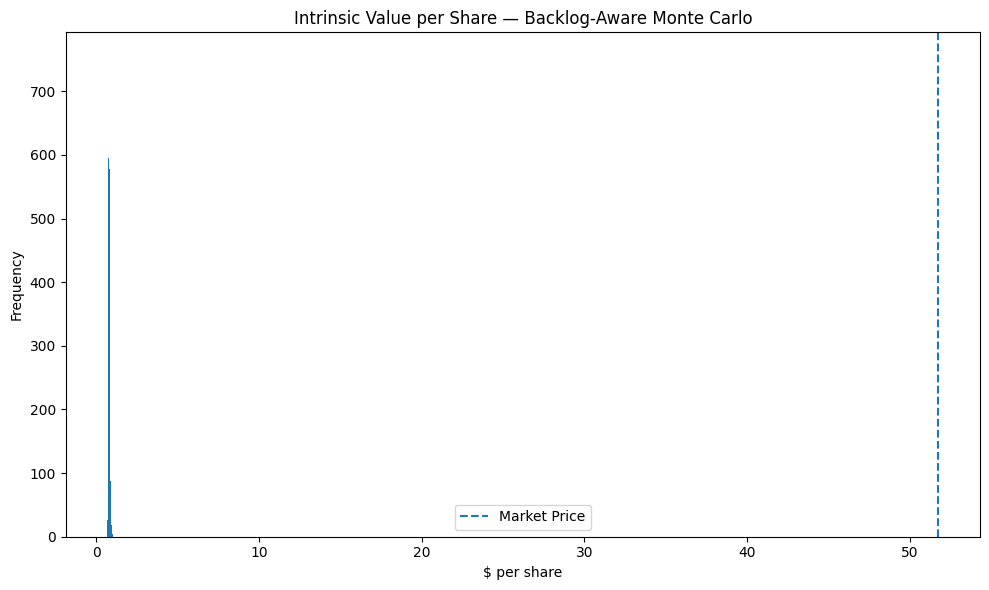

In [111]:
plt.hist(mc_results, bins=60)
plt.title('Intrinsic Value per Share — Backlog‑Aware Monte Carlo')
plt.xlabel('$ per share')
plt.ylabel('Frequency')
plt.axvline(price_hist['Close'].iloc[-1], linestyle='--', label='Market Price')
plt.legend()
plt.tight_layout()

In [112]:
pctls = [5,25,50,75,95]
values = np.percentile(mc_results, pctls)
for p,v in zip(pctls, values):
    print(f"{p}th percentile: ${v:,.2f}")
print(f"\nMean intrinsic value: ${mc_results.mean():,.2f}")
print(f"Current market price: ${price_hist['Close'].iloc[-1]:.2f}")

5th percentile: $0.72
25th percentile: $0.75
50th percentile: $0.78
75th percentile: $0.81
95th percentile: $0.86

Mean intrinsic value: $0.78
Current market price: $51.76


## 5  Template applicability to other sectors
To use this backlog‑aware template for a **different company or sector**, adjust:
1. **`backlog_current` & `burn_schedule`** — if the firm doesn’t disclose backlog, set these to 0 and rely on growth assumptions like the original DCF.
2. **`fcf_margin`** — use sector‐specific historical margin.
3. **`growth_sigma_non_backlog`** — industries with volatile demand (e.g., semiconductors) use higher σ.
4. **Capital intensity** — for banks/insurers, replace FCF with **dividend discount** or excess return models; DCF may be less informative.

> **Bottom line:** The Monte Carlo & dynamic WACC scaffolding is reusable, but **inputs/assumptions must reflect sector economics**.